# Task 4: Predicting the Winners in the Pokemon Battles

In this task, you need to use grid search to tune a single-hidden-layer neural network model to predict the winner of a battle between two Pokemons, which are referred to as the first and second Pokemons. Before training, you have to organize the data frames from Pokemon.csv and ```battles.csv``` so that the model takes the features of both Pokemons as input and predicts whether the first Pokemon wins using a binary label, with values 1 and 0 indicating that the first Pokemon wins and loses, respectively.

This time, you are required to evaluate your model on the test set q4 test.csv provided. You need to import ```q4_test.csv``` as a data frame and use the data to define input features for the model like what you did for the training data.

You are required to use the ```model selection``` submodule in ```scikit-learn``` to facilitate performing grid search cross validation for hyperparameter tuning. This is done by randomly sampling 80% of the training instances to train a classifier and then validating it on the remaining 20%. Five such random data splits are performed and the average over these five trials is used to estimate the generalization performance. You are expected to search at least 10 combinations of the hyperparameter setting.

In [1]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

In [2]:
# import csvs
pkdf = pd.read_csv('./pokemon.csv', sep=',', index_col="#")
btdf = pd.read_csv('./battles.csv', sep=',')
q4df = pd.read_csv('./q4_test.csv', sep=',')

In [3]:
# define function
# factorized
# for vlookup df's pokemon on pkdf and merge the features
# and one-hot encoding
def preprocess(df):
    # column of first pokemon wins
    df['First_Wins'] = (df['First_pokemon'] == df['Winner']) * 1
    
    
    # look up first pokemon
    r = df.merge(
        pkdf, 
        right_index=True, 
        left_on="First_pokemon", 
        how="left"
    )

    # drop unwanted features
    r = r.drop(
        columns = [
            "Name", 
            "WinRate"
        ]
    )

    # look up second pokemon
    r = r.merge(
        pkdf, 
        right_index=True,
        left_on="Second_pokemon", 
        how='left',
        suffixes=('_First', '_Second')
    )

    # drop unwanted features
    r = r.drop(
        columns = [
            'Name', 
            'First_pokemon', 
            'Second_pokemon', 
            'Winner', 
            'WinRate'
        ]
    )
    
    # return one-hot encoded dataframe
    return pd.get_dummies(r)

In [4]:
# do pre-processing on dataframes
ppbtdf = preprocess(btdf)
ppq4df = preprocess(q4df)

In [5]:
# get x y from processed battle df
X = ppbtdf.loc[:, ppbtdf.columns != 'First_Wins']
X = MinMaxScaler().fit_transform(X)

y = ppbtdf['First_Wins']

In [6]:
# split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=4211,
    shuffle=True
)

In [7]:
# set params, report back here
hss = [(2**i,) for i in range(1,3)]

grid_dist = {
    'hidden_layer_sizes': hss, # size refer to above
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd']
}

In [8]:
# define model
mlp = MLPClassifier(
    random_state = 4211,
    max_iter = 500,
    learning_rate_init = 1e-3,
    learning_rate = 'invscaling',
    n_iter_no_change = 10,
    early_stopping = True,
    tol = 1e-4,
    epsilon = 1e-8,
    verbose = False
)

grid_search = GridSearchCV(
    mlp,
    grid_dist,
    cv = 5
)

In [9]:
# run and this one needs somehow 15 minutes!
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=True,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='invscaling',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=500, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=4211, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid

In [10]:
# get test results
results = grid_search.cv_results_

# print 3 top scores
for i in range(1, 4):
    models = np.flatnonzero(results['rank_test_score'] == i)
    for m in models:
        print ("Rank {0} model:".format(i))
        print ("Mean : {0} , SD : {1}".format(
            results['mean_test_score'][m],
            results['std_test_score'][m]
        ))
        print ("With parameters: {0}".format(
            results['params'][m]
        ))
        print ("")

Rank 1 model:
Mean : 0.90246875 , SD : 0.0034536552194740036
With parameters: {'activation': 'relu', 'hidden_layer_sizes': (4,), 'solver': 'adam'}

Rank 2 model:
Mean : 0.8990625 , SD : 0.003947902924338457
With parameters: {'activation': 'relu', 'hidden_layer_sizes': (2,), 'solver': 'adam'}

Rank 3 model:
Mean : 0.8984687499999999 , SD : 0.0025221673467476355
With parameters: {'activation': 'tanh', 'hidden_layer_sizes': (2,), 'solver': 'adam'}



In [11]:
# predict
q4dt = ppq4df.loc[:, ppbtdf.columns != 'First_Wins']
ppq4 = MinMaxScaler().fit_transform(q4dt)

# gs.best_estimator_.predict = gs.predict
Q4pred = grid_search.predict(ppq4)

q4y = ppq4df['First_Wins']

print("Classification report for classifier %s:\n%s\n"
      % (
          grid_search.best_estimator_, 
          classification_report(q4y, Q4pred)
      ))


Classification report for classifier MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(4,), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=4211, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False):
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      5282
           1       0.91      0.88      0.90      4718

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000




Text(0.5, 0.98, 'Confusion Matrix')

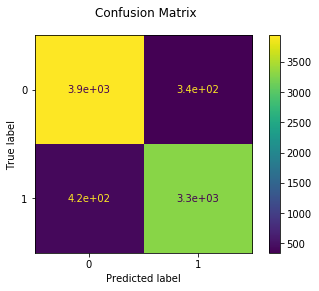

In [12]:
# confusion matrix
disp = plot_confusion_matrix(grid_search, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")

In [13]:
print("Confusion matrix:\n%s" % disp.confusion_matrix)

Confusion matrix:
[[3935  345]
 [ 417 3303]]
